In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import shutil
import sys
import time
import pprint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# print(tf.__version__)
# print(sys.version_info)
# for module in mpl, np, pd, sklearn, tf, keras:
#     print(module.__name__, module.__version__) 

In [27]:
#layer useage

#layer = tf.keras.layers.Dense(100)
#layer = tf.keras.layers.Dense(100,input_shape=(None,5)) #指定输入形式
#layer(tf.zeros([10,5]))

#layer.variables
# x*w + b
#layer.trainable_variables     #可训练变量
#help(layer)

In [28]:
#数据
housing = fetch_california_housing()
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)


# x = (x-u)/std（归一化）
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32))
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32))
x_test_scaled = scaler.transform(
    x_test.astype(np.float32))

In [33]:
#tf.nn.softplus : log(1+e^x)
customized_softplus = keras.layers.Lambda(lambda x:tf.nn.softplus(x))
print(customized_softplus([-10.,-5.,0.,5.,10.]))

tf.Tensor([4.5417706e-05 6.7153489e-03 6.9314718e-01 5.0067153e+00 1.0000046e+01], shape=(5,), dtype=float32)


In [35]:
# def customize_mse(y_true,y_pred):
#     return tf.reduce_mean(tf.square(y_pred-y_true))

#customized dense layer
class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer,self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        """构建参数"""
        #x * w +b. input_shape:(None,a), w[a,b] output_shape: [None,b ] 
        self.kernel = self.add_weight(name = 'kernel',
                                      shape = (input_shape[1],self.units),
                                      initializer = 'uniform',
                                      trainable = True)
        self.bias = self.add_weight(name = 'bias',
                                   shape = (self.units,),
                                   initializer = 'zeros',
                                   trainable = True)
        super(CustomizedDenseLayer,self).build(input_shape)
        
        def call(self,x):
            # 完成正向计算
            result = x@self.kernel + self.bias
            print(result.value().shape)
            return self.activation(x @ self.kernel + self.bias)

# model = keras.models.Sequential([
#     CustomizedDenseLayer(units=30,activation='relu',
#                       input_shape=x_train.shape[1:]),
#     CustomizedDenseLayer(1),
#     customize_softplus,        
# ])

inputi = keras.layers.Input(shape=x_train.shape[1:])
hidden = CustomizedDenseLayer(30,activation='relu')(inputi)
output = CustomizedDenseLayer(1,activation='relu')(hidden)
model = keras.models.Model(inputs=[inputi],outputs=[output])        
        
# model = keras.models.Sequential([
#     keras.layers.Dense(units=30,activation='relu',
#                       input_shape=x_train.shape[1:]),
#     keras.layers.Dense(1)
# ])
model.compile(loss='mean_squared_error' ,optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
customized_dense_layer_26 (C (None, 8)                 270       
_________________________________________________________________
customized_dense_layer_27 (C (None, 8)                 9         
Total params: 279
Trainable params: 279
Non-trainable params: 0
_________________________________________________________________


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 48us/sample - loss: 1.7198 - val_loss: 0.5588
Epoch 2/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4528 - val_loss: 0.4349
Epoch 3/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4031 - val_loss: 0.4009
Epoch 4/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3843 - val_loss: 0.3881
Epoch 5/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3838 - val_loss: 0.3763
Epoch 6/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3816 - val_loss: 0.3816
Epoch 7/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3735 - val_loss: 0.3733
Epoch 8/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3668 - val_loss: 0.3709
Epoch 9/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.363

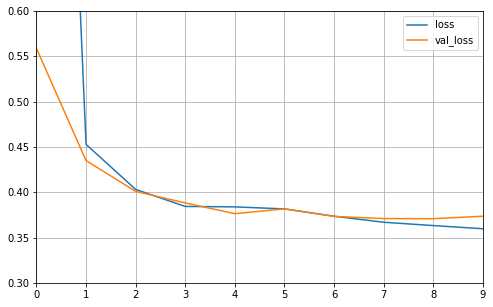

In [31]:
history = model.fit(x_train_scaled,y_train,
                    validation_data=(x_valid_scaled,y_valid),
                   epochs=100,
                   callbacks = callbacks)
def plot_learning_curves(his):
        pd.DataFrame(his.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0.3,0.6)
        plt.show()
        
plot_learning_curves(history)

In [32]:
model.evaluate(x_test_scaled,y_test)

5160/5160 [==============================] - 0s 17us/sample - loss: 0.3827


0.3827272061229676